### Data-vector blinding for the power spectrum multipoles

Example notebook showing how to implement the data-vector level blinding for the galaxy power spectrum multipoles.

In [17]:
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, REPTVelocileptorsTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.emulators import EmulatedCalculator
from desilike.samplers import EmceeSampler
from desilike.profilers import MinuitProfiler
from desilike.samples import Profiles
from desilike import setup_logging

from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.theories import Cosmoprimo
from desilike.samples import Profiles, Chain
from cosmoprimo.fiducial import AbacusSummit

from desiblind import TracerPowerSpectrumMultipolesBlinder

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'


def get_tracer_label(tracer):
    return tracer.split('_')[0].replace('+', 'plus')

def get_theory():
    """Instance of desilike theory model"""
    from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate, DirectPowerSpectrumTemplate, REPTVelocileptorsTracerPowerSpectrumMultipoles
    from desilike.theories import Cosmoprimo

    cosmo = DirectPowerSpectrumTemplate(fiducial='DESI').cosmo
    cosmo.init.params['sigma8_m'] = {'derived': True, 'latex': r'\sigma_8'}  # derive sigma_8
    cosmo.init.params['tau_reio'].update(fixed=True)
    cosmo.init.params['omega_b'].update(fixed=False, prior={'dist': 'norm', 'loc': 0.02218, 'scale': (3.025e-7)**0.5})
    cosmo.init.update(engine='class')
    
    template = DirectPowerSpectrumTemplate(z=window.theory.get(ells=0).z, fiducial='DESI', cosmo=cosmo)
    print(tracer)
    theory = REPTVelocileptorsTracerPowerSpectrumMultipoles(template=template, tracer=tracer_label, prior_basis='physical', freedom='max')
    return theory

def get_synthetic_data(statistic='mesh2_spectrum_poles', tracer='LRG', zmin=0.4, zmax=0.6,
    region='GCcomb', ells=[0, 2, 4], weights='default_fkp', kmin=0.0, kmax=0.3, rebin=5):
    """Synthetic data from Abacus-HF mocks for testing."""
    import lsstypes as types
    dirname = Path('/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/unblinded_data/dr2-v2/')
    covariance = types.read(dirname / f'covariance_{statistic}_{tracer}_z{zmin}-{zmax}_{region}_{weights}.h5')
    observable = covariance.observable.select(k=slice(0, None, rebin)).select(k=(kmin, kmax)).get(ells=ells)
    covariance = covariance.at.observable.match(observable)
    
    window = types.read(dirname / f'window_{statistic}_{tracer}_z{zmin}-{zmax}_{region}_{weights}.h5')
    window = window.at.observable.match(observable)
    window = window.at.theory.select(k=(0, 0.35))

    return observable, covariance, window

def DESIFSLikelihood(tracers=None, cosmo=None, klim=(0.02, 0.2), solve='.auto'):
    """Create DESI FS likelihood."""

    if cosmo is None:
        cosmo = DirectPowerSpectrumTemplate(fiducial='DESI').cosmo
        cosmo.init.params['sigma8_m'] = {'derived': True, 'latex': '\sigma_8'}  # derive sigma_8
        cosmo.init.params['tau_reio'].update(fixed=True)
        cosmo.init.params['omega_b'].update(fixed=False, prior={'dist': 'norm', 'loc': 0.02218, 'scale': (3.025e-7)**0.5})
        cosmo.init.update(engine='class')

    this_zrange = []
    for tracer, iz, zrange in list_zrange:
        tracer_label = get_tracer_label(tracer)
        namespace = '{tracer}_z{iz}'.format(tracer=tracer_label, iz=iz)
        if tracers is not None and namespace.lower() not in tracers: continue
        this_zrange.append((tracer, iz, zrange, namespace))

    observables = []
    likelihoods = []

    for tracer, iz, zrange, namespace in this_zrange:
        print('Adding DESI FS likelihood for tracer {}, zrange {}, namespace {}'.format(tracer, zrange, namespace))

        data, covariance, window = get_synthetic_data(
            tracer=tracer,
            zmin=zrange[0],
            zmax=zrange[1],
            region='GCcomb',
            ells=[0, 2, 4],
            weights='default_fkp',
            kmin=0.0,
            kmax=0.3,
            rebin=5
        )

        template = DirectPowerSpectrumTemplate(z=window.theory.get(ells=0).z, fiducial='DESI', cosmo=cosmo)
        theory = REPTVelocileptorsTracerPowerSpectrumMultipoles(template=template, tracer=tracer_label, prior_basis='physical', freedom='max')
        observable = TracerPowerSpectrumMultipolesObservable(
            data=data,
            theory=theory,
            covariance=covariance,
            wmatrix=window,
        )

        # Compute or swap in PT emulator
        emu_fn = Path(f'../scripts/emulator_fs_{namespace}.npy')

        if emu_fn.exists():
            calculator = EmulatedCalculator.load(emu_fn)
            # Update emulator with cosmo
            if cosmo is not None:
                for param in cosmo.init.params:
                    if param in calculator.init.params:
                        calculator.init.params.set(param)
            theory.init.update(pt=calculator)
        else:
            observable()  # to set up k-ranges for the emulator
            from desilike.emulators import Emulator, TaylorEmulatorEngine
            theory = observable.wmatrix.theory
            #theory.init.update(ells=(0, 2, 4))  # train emulator on all multipoles
            emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(method='finite', order=4))
            emulator.set_samples()
            emulator.fit()
            emulator.save(emu_fn)

        # Update namespace of bias parameters (to have one parameter per tracer / z-bin)
        for param in theory.init.params:
            # Update latex just to have better labels
            param.update(namespace=namespace,
                         latex=param.latex(namespace=r'\mathrm{{{}}}, {:d}'.format(tracer_label, iz), inline=False))
        

        likelihood = ObservablesGaussianLikelihood(observable, name=namespace)
        likelihoods.append(likelihood)

    #likelihood = sum(likelihoods)  # likelihood is a callable that returns the log-posterior
    if len(likelihoods) > 1: likelihood = sum(likelihoods)
    else: likelihood = likelihoods[0]  # to avoid duplicate loglikelihood derived parameter in cobaya when using multiple likelihoods independently

    if solve:
        for param in likelihood.all_params.select(basename=['alpha*', 'sn*', 'c*']):
            if param.varied: param.update(derived=solve)

        if likelihood.mpicomm.rank == 0:
            likelihood.log_info('Use analytic marginalization for {}.'.format(likelihood.all_params.names(solved=True)))


    return likelihood

The blinding procedure does the following:

$P_{\rm blind}(k) = P(k) - W(k, k') P_{\rm ref}(k) + W(k, k') P_{\rm shift}(k)$,

where $P_{\rm ref}(k)$ is computed with a *reference* cosmology (reasonably a good match to the data), while 
$P_{\rm shift}(k)$ is computed with a *shift* cosmology (the blinding cosmology).

In [18]:
# we read the reference parameters from a joint full-shape fit to all GQC tracers

profiles = Profiles.load('../scripts/profiles/profiles_abacushf_fs.npy')
bestfit = profiles.bestfit.choice(index='argmax', input=True)

In [31]:
list_zrange = [
    ('BGS_BRIGHT-21.35', 0, (0.1, 0.4)), 
    ('LRG', 0, (0.4, 0.6)),
    ('LRG', 1, (0.6, 0.8)),
    ('LRG', 2, (0.8, 1.1)),
    ('ELG_LOPnotqso', 1, (1.1, 1.6)),
    ('QSO', 0, (0.8, 2.1)),
]

tracers = [
    'bgs_z0',
    'lrg_z0',
    'lrg_z1',
    'lrg_z2',
    'elg_z1',
    'qso_z0'
]

klim = (0.02, 0.2)

dr2_like = DESIFSLikelihood(
    tracers=tracers,
    cosmo=None,
    klim=klim,
    solve='.auto',
)

Adding DESI FS likelihood for tracer BGS_BRIGHT-21.35, zrange (0.1, 0.4), namespace BGS_z0
Adding DESI FS likelihood for tracer LRG, zrange (0.4, 0.6), namespace LRG_z0
Adding DESI FS likelihood for tracer LRG, zrange (0.6, 0.8), namespace LRG_z1
Adding DESI FS likelihood for tracer LRG, zrange (0.8, 1.1), namespace LRG_z2
Adding DESI FS likelihood for tracer ELG_LOPnotqso, zrange (1.1, 1.6), namespace ELG_z1
Adding DESI FS likelihood for tracer QSO, zrange (0.8, 2.1), namespace QSO_z0


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/code/desilike/lsstypes/lib/python3.10/site-packages/desilike/base.py:447: UserWarning: Derived parameter sigma8_m of <desilike.theories.galaxy_clustering.full_shape.REPTVelocileptorsPowerSpectrumMultipoles object at 0x7eff1475f430> is already derived in <desilike.theories.galaxy_clustering.full_shape.REPTVelocileptorsPowerSpectrumMultipoles object at 0x7eff1473b130>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/code/desilike/lsstypes/lib/python3.10/site-packages/desilike/base.py:447: UserWarning: Derived parameter sigma8_m of <desilike.theories.galaxy_clustering.full_shape.REPTVelocileptorsPowerSpectrumMultipoles object at 0x7eff1473a8f0> is already derived in <desilike.theories.galaxy_clustering.full_shape.REPTVelocileptorsPowerSpectrumMultipoles object at 0x7eff1475f430>.
  if self.mpicomm.rank == 0: warnings.warn

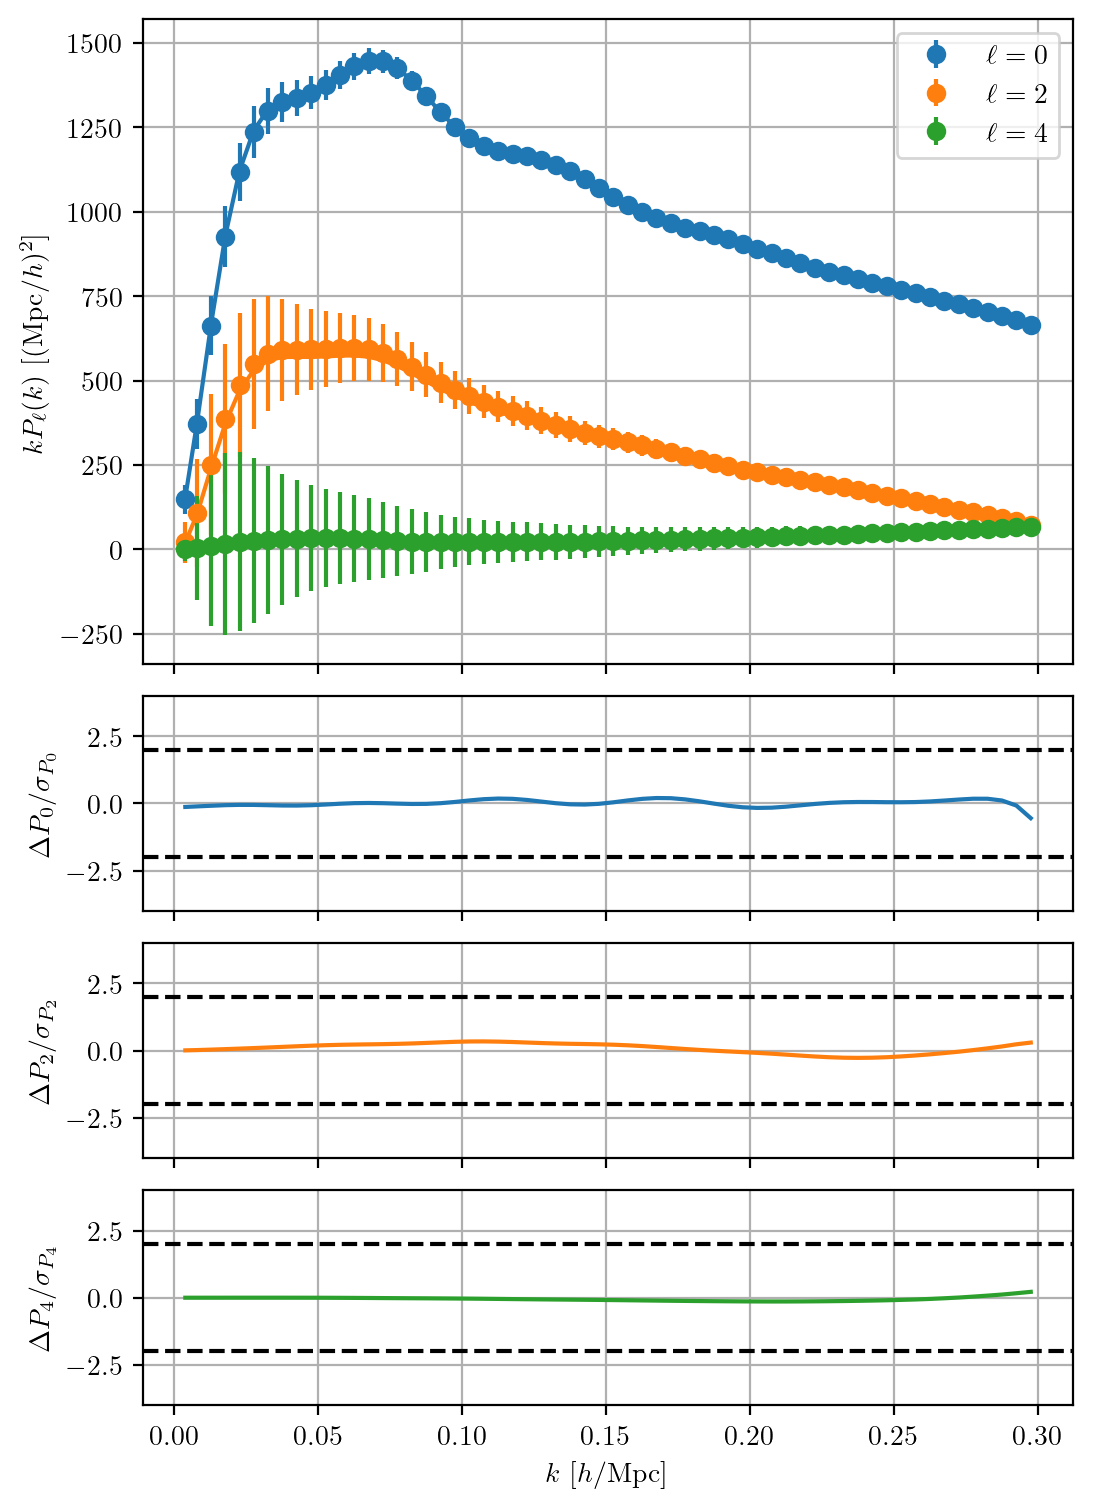

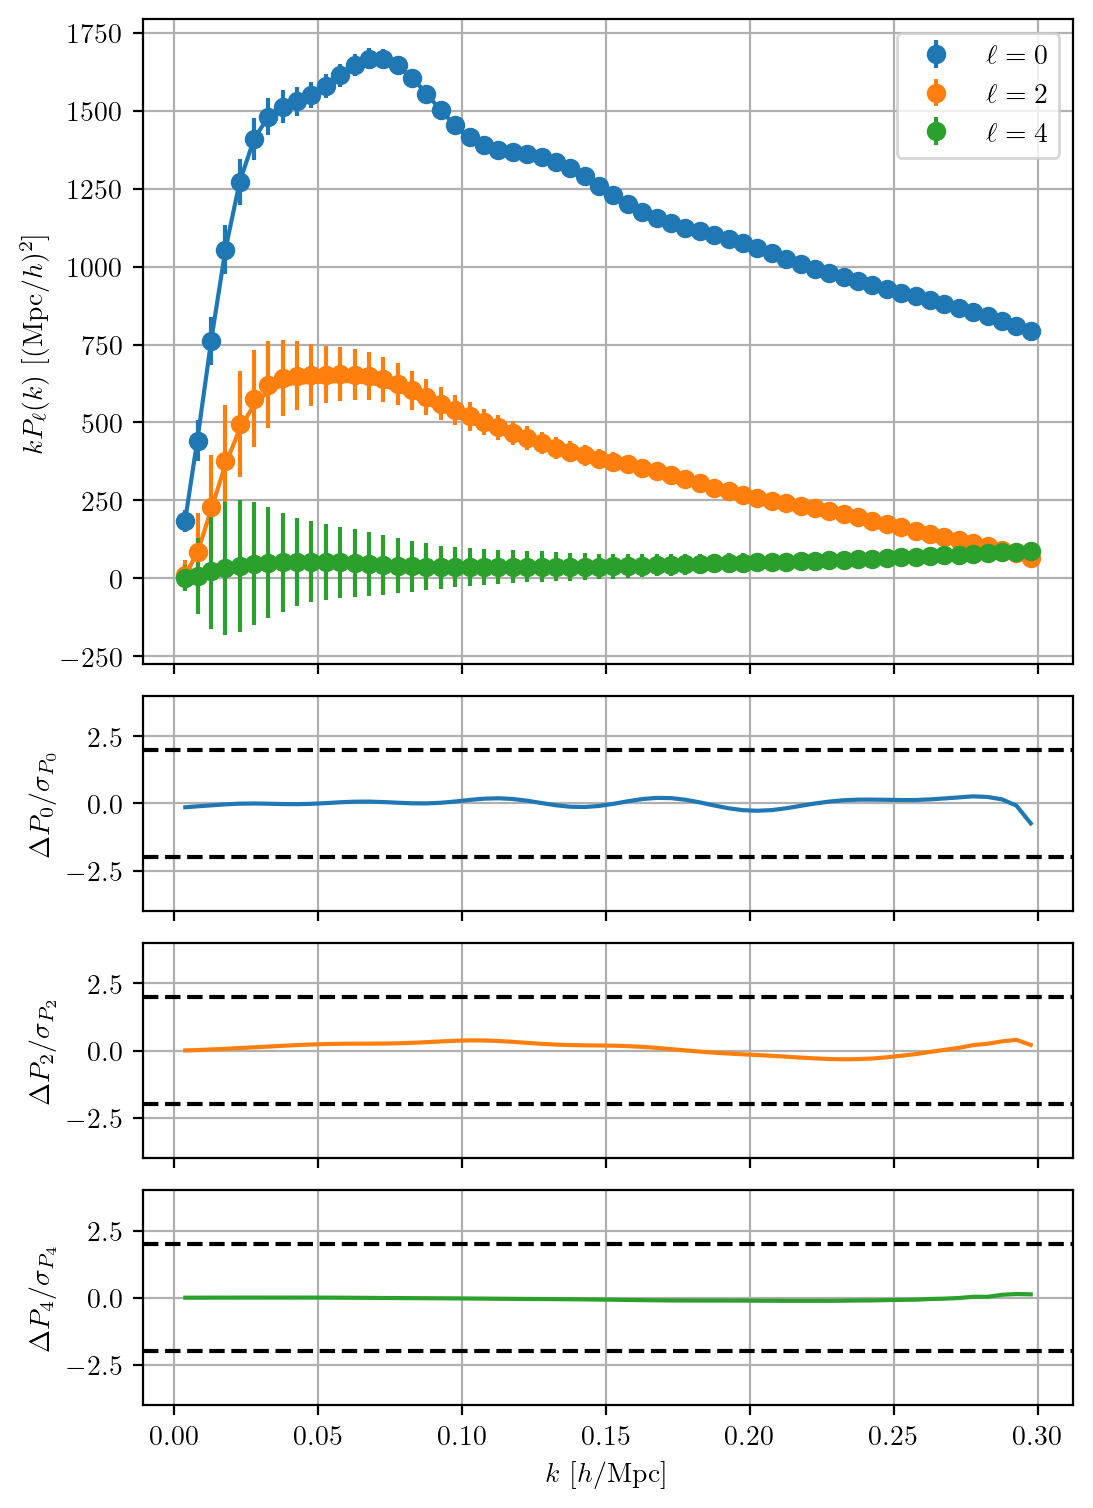

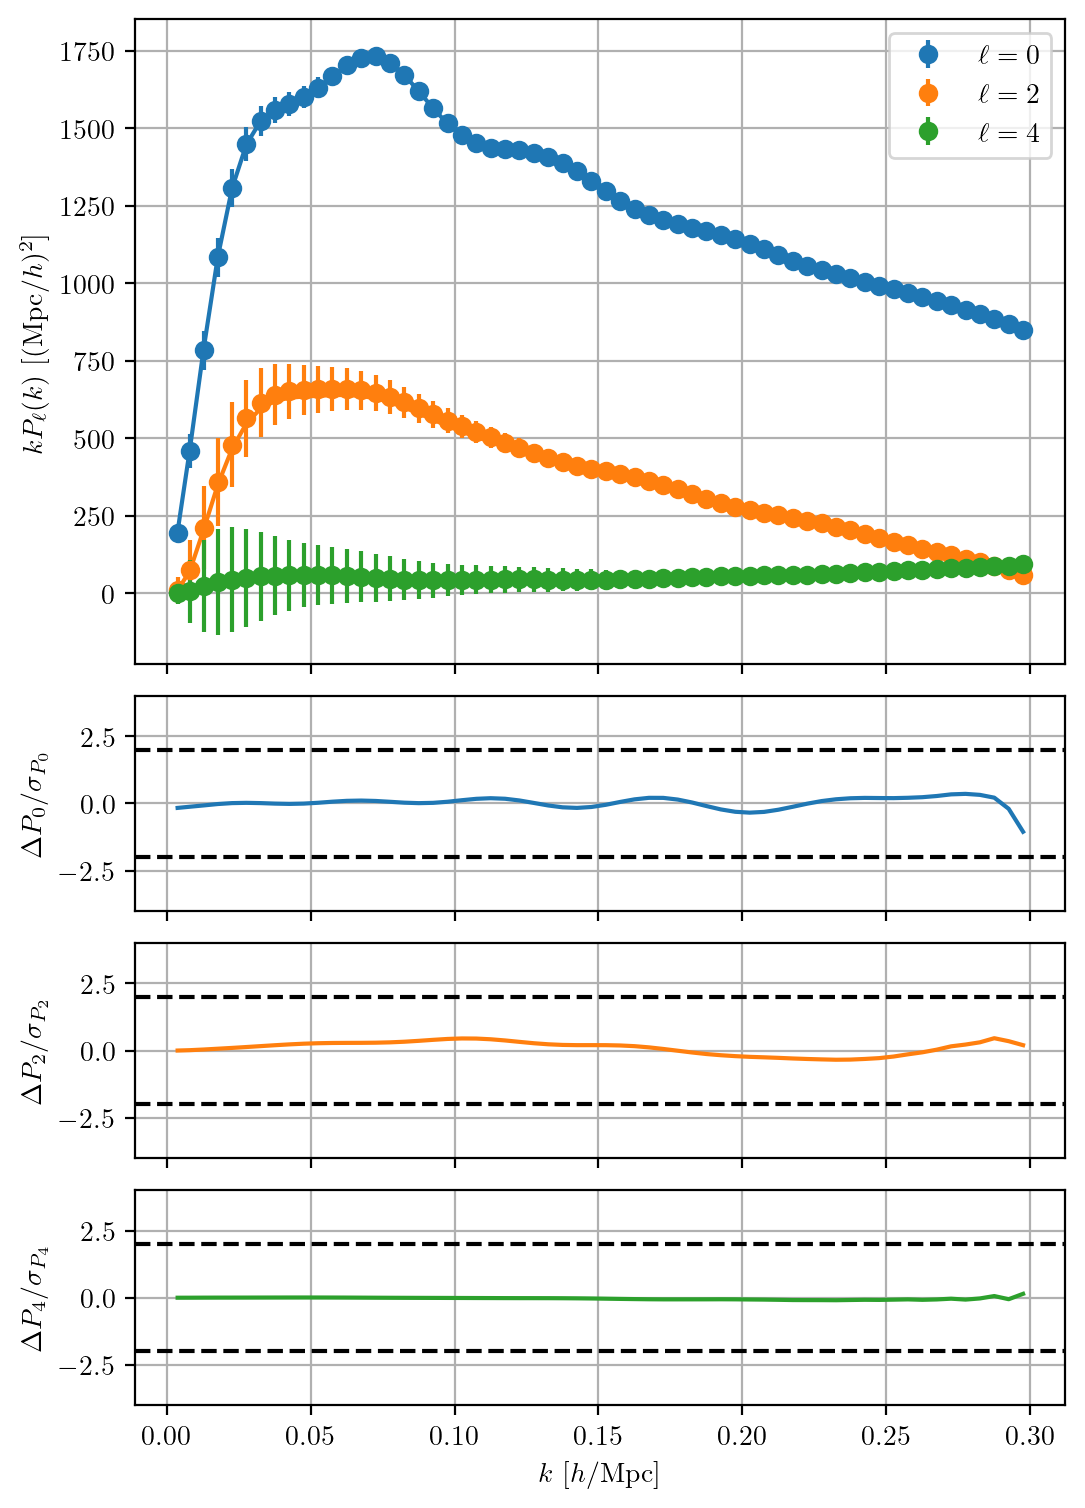

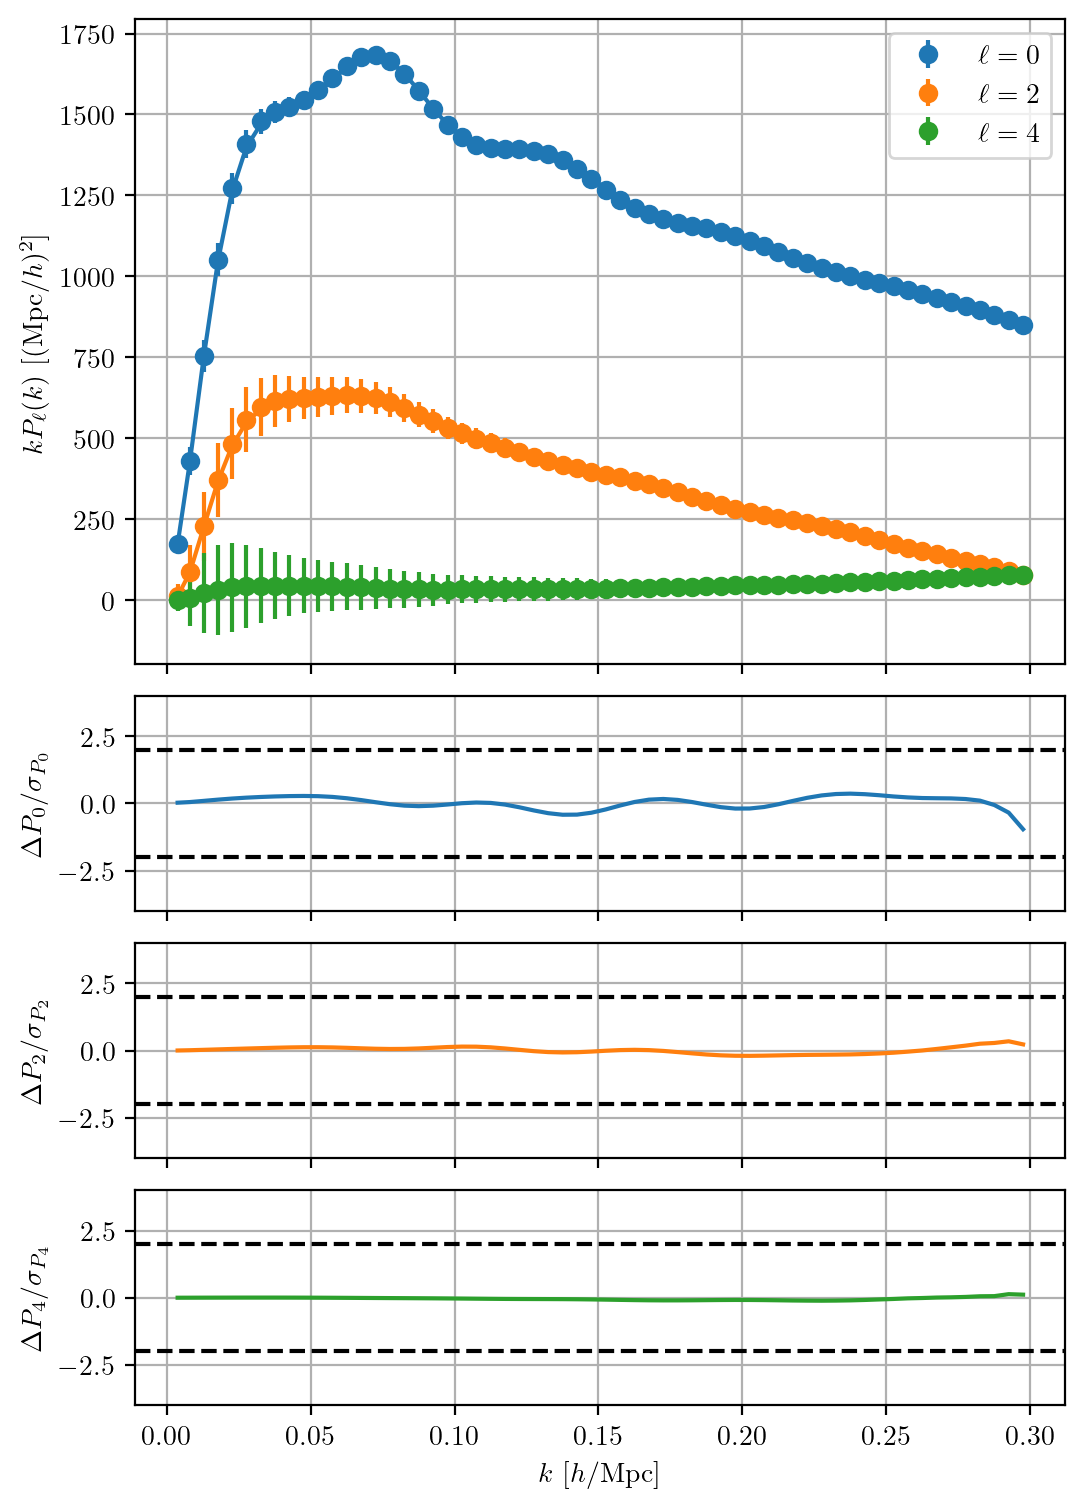

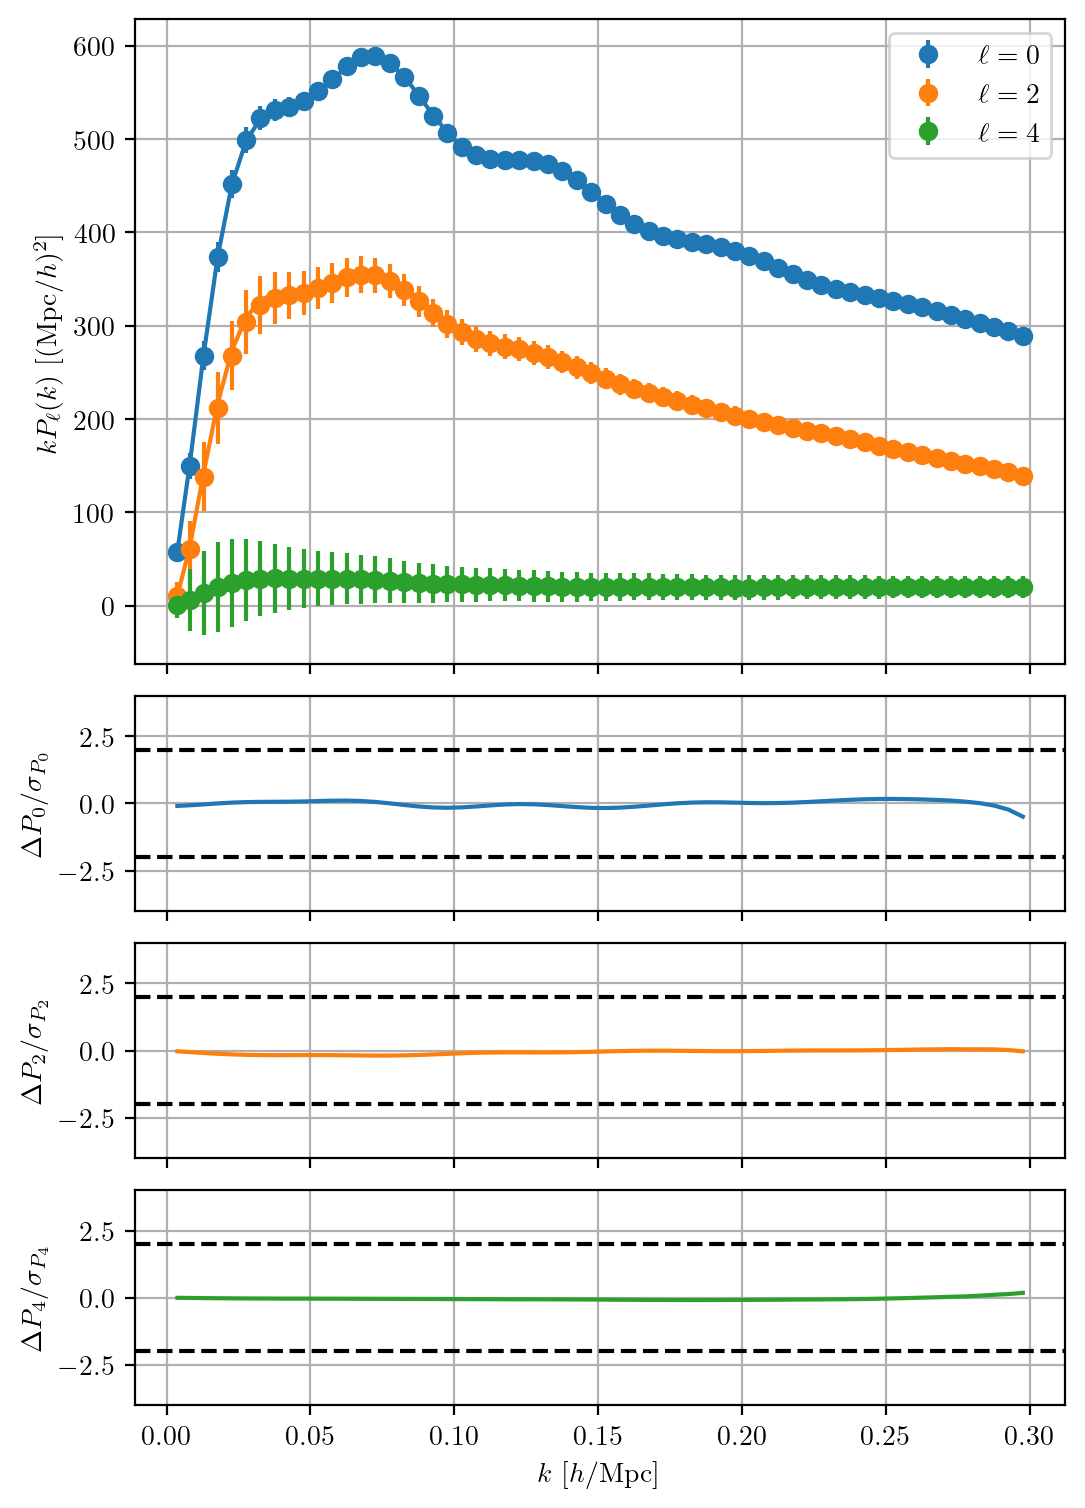

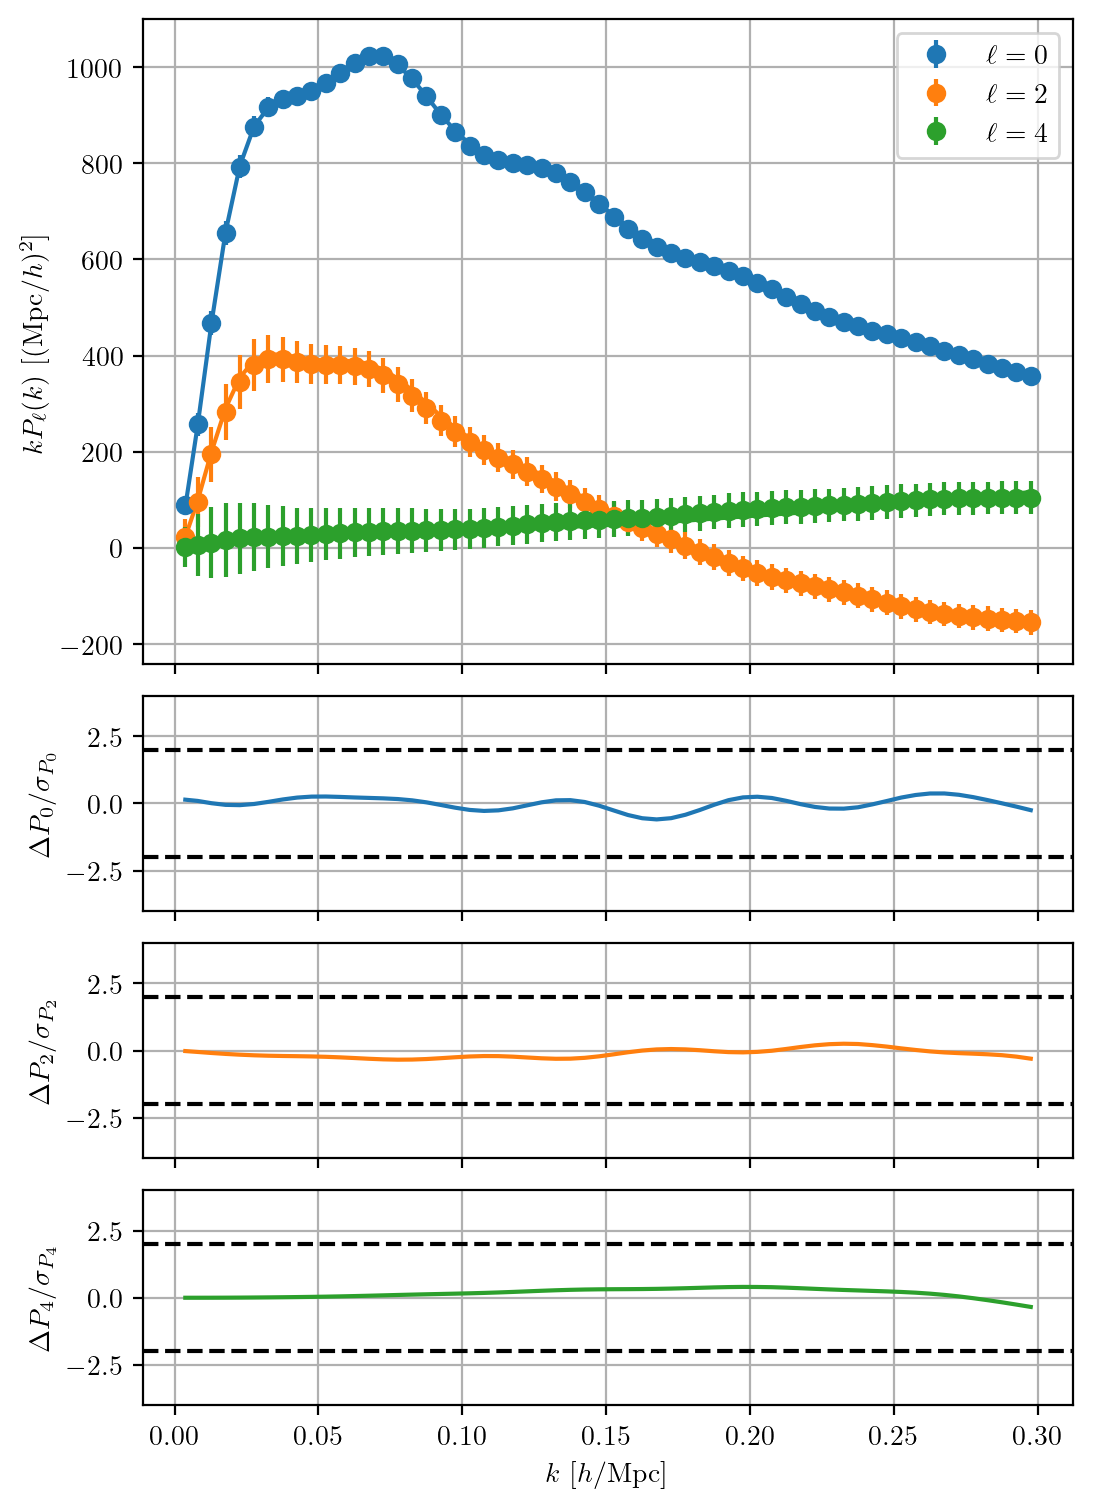

In [32]:
# we instantiate TracerPowerSpectrumMultipolesBlinder, which will provides
# the necessary tools to apply the blinding. We then loop over tracers
# and add their likelihood to the blinder.

blinder = TracerPowerSpectrumMultipolesBlinder()

cosmo_param_names = ['h', 'omega_cdm', 'omega_b', 'logA']
nuisance_param_names = nuisance_param_names = ['b1p', 'b2p', 'bsp', 'alpha0p', 'alpha2p', 'alpha4p', 'sn0p', 'sn2p', 'sn4p']
for likelihood in dr2_like.likelihoods:
    namespace = likelihood.name
    observable = likelihood.observables[0]
    tracer = namespace[:3]

    cosmo_params = {param: bestfit[f'{param}'].value for param in cosmo_param_names}
    nuisance_params = {f'{namespace}.{param}': bestfit[f'{namespace}.{param}'].value for param in nuisance_param_names}
    reference_params = cosmo_params | nuisance_params

    likelihood(**reference_params)
    
    blinder.add_observable(
        name=namespace,
        likelihood=likelihood,
        reference_params=reference_params
    )

    observable.plot()
    

In [8]:
# # we instantiate TracerPowerSpectrumMultipolesBlinder, which will provides
# # the necessary tools to apply the blinding. We then loop
# blinder = TracerPowerSpectrumMultipolesBlinder()

# # we then loop over each tracer and use the .add_observable method to add their
# # data to the blinding class. We note that the "nuisance parameters" are different
# # for each tracer (the Profile/Chain files have entries like "LRG_z0_b1p".

# list_zrange = [
#     ('BGS_BRIGHT-21.35', 0, (0.1, 0.4)), 
#     ('LRG', 0, (0.4, 0.6)),
#     ('LRG', 1, (0.6, 0.8)),
#     ('LRG', 2, (0.8, 1.1)),
#     ('ELG_LOPnotqso', 1, (1.1, 1.6)),
#     ('QSO', 0, (0.8, 2.1)),
# ]

# region = 'GCcomb'
# ells = [0, 2, 4]
# cosmo_param_names = ['h', 'omega_cdm', 'omega_b', 'logA']
# nuisance_param_names = nuisance_param_names = ['b1p', 'b2p', 'bsp', 'alpha0p', 'alpha2p', 'alpha4p', 'sn0p', 'sn2p', 'sn4p']

# for tracer, iz, zrange in list_zrange:
#     tracer_label = get_tracer_label(tracer)
#     namespace = '{tracer}_z{iz}'.format(tracer=tracer_label, iz=iz)
#     zmin, zmax = zrange

#     # k, poles, covariance, window = get_synthetic_data(tracer=tracer, zmin=zmin, zmax=zmax, region=region, ells=ells)
#     data, covariance, window = get_synthetic_data(tracer=tracer, zmin=zmin, zmax=zmax, region=region, ells=ells)
#     theory = get_theory()
#     # theory.init.update(k=window.theory.get(ells=0).coords('k'))

#     observable = TracerPowerSpectrumMultipolesObservable(
#         data=data,
#         theory=theory,
#         covariance=covariance,
#         wmatrix=window,
#     )

#     likelihood = ObservablesGaussianLikelihood(observable)

#     cosmo_params = {param: bestfit[f'{param}'].value for param in cosmo_param_names}
#     nuisance_params = {param: bestfit[f'{namespace}.{param}'].value for param in nuisance_param_names}
#     reference_params = cosmo_params | nuisance_params

#     print(reference_params)

#     likelihood(**reference_params)
    
#     # blinder.add_observable(
#     #     name=namespace,
#     #     likelihood=likelihood,
#     #     reference_params=reference_params
# # )

In [9]:
chain_dir = '/global/cfs/cdirs/desicollab/users/epaillas/code/desiblind/scripts/chains/'
chain_fn = Path(chain_dir) / 'chain_abacushf_fs_0.npy'
chain = Chain.load(chain_fn).ravel()[::10]

# alpha = 0.5
# p = np.exp(-alpha * chain['logposterior'])
# mask = np.isfinite(p)
# chain = chain[mask]

In [137]:
# from desilike.samples import plotting
# %matplotlib inline

# plotting.plot_triangle(chain, params=['omega_b', 'omega_cdm', 'sigma8_m', 'h'], title_limit=1)

# plt.savefig('posterior.pdf')
# plt.show()

In [10]:
import random

# randomly draw 10 samples from the posterior
# alpha = 0.5
# p = np.exp(-alpha * chain['logposterior'])
# idx = random.choices(np.arange(len(chain)), k=10, weights=p)
idx = random.choices(np.arange(len(chain)), k=20)
posterior_samples = chain[idx]

In [33]:
# we now apply the blinding to each tracer. the "shifted_params" are provided
# to the .apply_blinding method. Parameters that are not included in the shifted
# dictionary default to the reference values defined earlier

# note that the shifted parameters are defined manually in the example below,
# but ideally we would be sampling them directly from a chain

for i in range(len(posterior_samples)):
    sample = posterior_samples[i]
    
    for likelihood in dr2_like.likelihoods:
        namespace = likelihood.name
        observable = likelihood.observables[0]
        tracer = namespace[:3]

        cosmo_params = {param: sample[f'{param}'].value[0] for param in cosmo_param_names}
        nuisance_params = {f'{namespace}.{param}': sample[f'{namespace}.{param}'].value[0] for param in nuisance_param_names}
        shifted_params = cosmo_params | nuisance_params

        blinder._apply_blinding(
            name=namespace,
            shifted_params=shifted_params,
        )
    
# for instance, the two blinded data vectors for LRG1 can be accessed as
# blinder.LRG_z0.blinded_data , which will yield an array of shape
# (n_blinding, n_multipoles, k_bins)

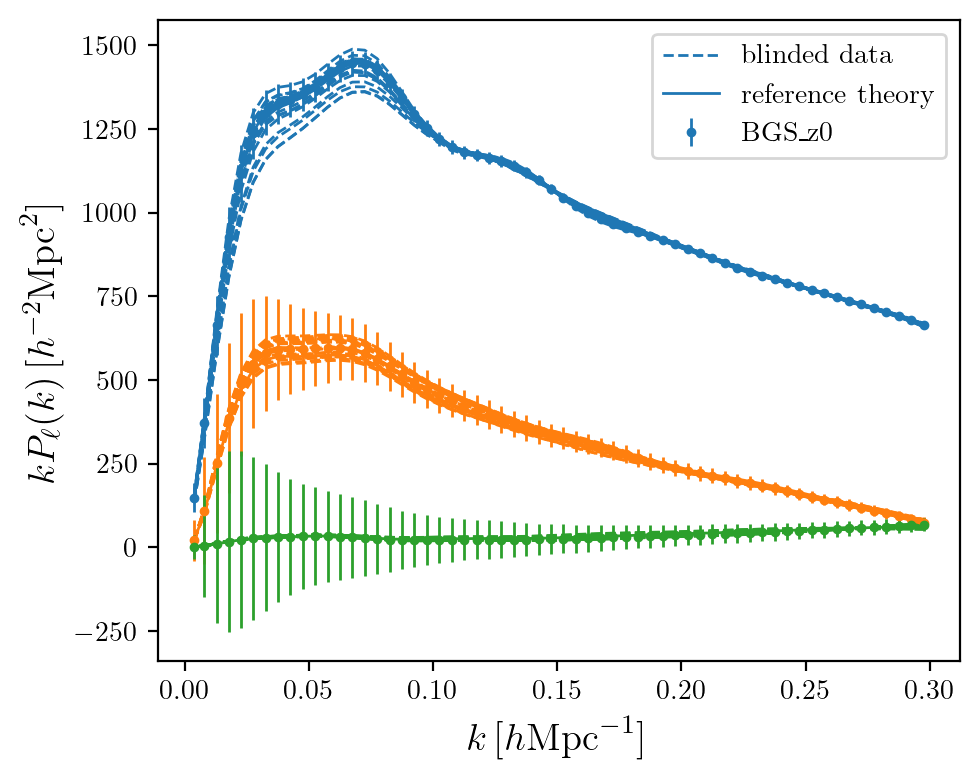

In [34]:
# we can plot the original and blinded data, together with the reference theory.
# blinded_ids specify which blinding realization we want to show
fig, ax = blinder.plot_observables(name='BGS_z0', show_blinded=True, blinded_ids=list(range(20)))

In [35]:
# we save the shifts that are needed to blind the measurements to disk.
# this will then allow us to use those shifts to blind any input data
# without having to go through all the trouble we set up above

blinder.save_blinded_data(save_dir='/global/cfs/cdirs/desicollab/users/epaillas/y3-growth/dump')

In [40]:
# load the shifts and use a high-level method that blinds input data.

observable, covariance, window = get_synthetic_data(
    tracer='LRG',
    zmin=0.4,
    zmax=0.6,
    region='GCcomb',
    ells=[0, 2, 4]
)

poles = [observable.get(ell) for ell in [0, 2, 4]]
k = poles[0].coords('k')
poles = [pole.value() for pole in poles]

blinded_data = TracerPowerSpectrumMultipolesBlinder.apply_blinding(
    name='LRG_z0',  # TODO add an internal function so that the user only needs to pass tracer name, zmin, zmax?
    k=k,
    data=poles,
    ells=[0, 2, 4],
)

np.shape(blinded_data)

(3, 60)

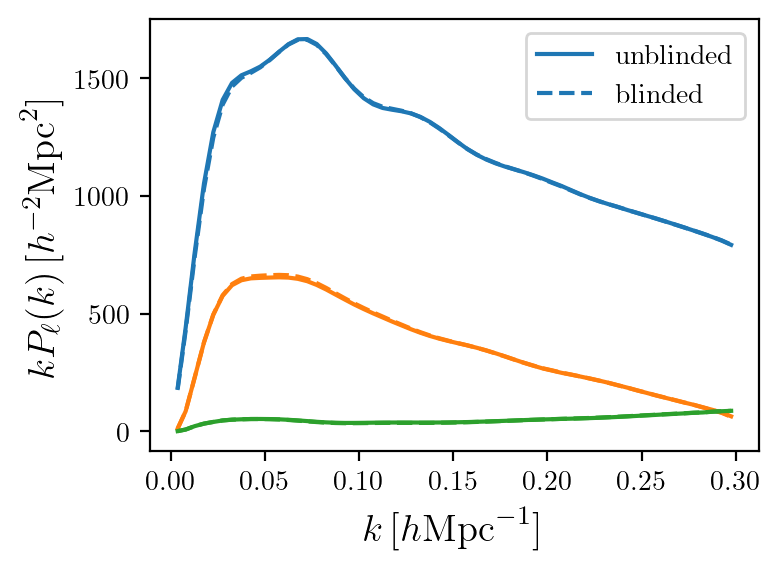

In [41]:
# let's plot it

fig, ax = plt.subplots(figsize=(4, 3))

for iell, ell in enumerate([0, 2, 4]):
    ax.plot(k, k * poles[iell], label='unblinded' if iell == 0 else None, color=f'C{iell}')
    ax.plot(k, k * blinded_data[iell], label='blinded' if iell == 0 else None, color=f'C{iell}', ls='--')

ax.legend()
ax.set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$k P_\ell(k)\,[h^{-2}{\rm Mpc}^{2}]$', fontsize=14)
plt.tight_layout()
plt.show()